In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [3]:
user,item,title = 'userId','movieId','title'

In [4]:
path = untar_data(URLs.ML_SAMPLE,None,'d:\.fastai/data')
path

WindowsPath('d:/.fastai/data/movie_lens_sample')

In [9]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [11]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [7]:
y_range = [0,5.5]

In [15]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [16]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.609912,0.967003,00:33
1,0.847790,0.667758,00:33
2,0.648648,0.662552,00:33


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [19]:
Config.DEFAULT_CONFIG = {
        'data_path': 'd:/.fastai/data',
        'model_path': 'd:/.fastai/models'
    }
Config.create('d:/fastaiconfig.yml')
Config.DEFAULT_CONFIG_PATH = 'd:/fastaiconfig.yml'
path=Config.data_path()/'ml-100k'
path

WindowsPath('d:/.fastai/data/ml-100k')

In [21]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [22]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
len(ratings)

100000

In [52]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()


,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [53]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [54]:
data.show_batch()

userId,title,target
380,"Usual Suspects, The (1995)",5.0
361,Natural Born Killers (1994),2.0
924,Independence Day (ID4) (1996),4.0
293,Snow White and the Seven Dwarfs (1937),3.0
484,"Hunt for Red October, The (1990)",5.0


In [55]:
y_range = [0,5.5]

In [56]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1) 
#y_range makes the range to sigmoid functiom
#wd mean: weight decay, the parameter that multiplied to the sum squre of all weights
#n_factors is width of embedding matrix (the number of features)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


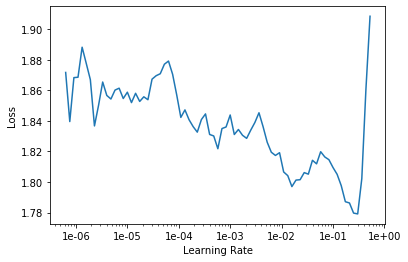

In [57]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [30]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.958380,0.952254,00:40
1,0.840733,0.876827,00:41
2,0.747440,0.833860,00:41
3,0.650849,0.811162,00:41
4,0.558523,0.810539,00:41


In [58]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [59]:
learn.load('dotprod');

In [60]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [34]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [35]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [97]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]


In [96]:
#len(top_movies), len(movie_bias),top_movies, movie_bias,mean_ratings,movie_ratings
#a = zip(top_movies,movie_bias)
#list(a)

In [98]:
item0 = lambda o:o[0]

In [99]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3629),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2965), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2807),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2632), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2596), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2579), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2455), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2371), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2340), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2288), 'Hellraiser: Bloodline (1996)', 2.0),
 (tensor(-0.2213), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2184), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2181), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2161), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2073), 'Crow: City of Angels, The (19

In [100]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6268), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5703), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5693), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5564), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5372), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5294), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5276), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5225), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4908), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4891), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4858), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.4795), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4770), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4764), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4739), 'To Kill a Mockingbird (1962)', 4.292237442922374)]

### Movie weights

In [103]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [104]:
movie_pca = movie_w.pca(3) #pca:principal component analysis
movie_pca.shape

torch.Size([1000, 3])

In [113]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]
movie_pca.t(),movie_comp

(tensor([[ 0.0105, -0.0061, -0.0010,  ...,  0.0054,  0.0050, -0.0198],
         [-0.0001,  0.0106,  0.0018,  ..., -0.0134, -0.0133, -0.0037],
         [ 0.0204, -0.0036, -0.0129,  ...,  0.0026,  0.0091, -0.0153]]),
 [(tensor(0.0105), 'Star Wars (1977)'),
  (tensor(-0.0061), 'Contact (1997)'),
  (tensor(-0.0010), 'Fargo (1996)'),
  (tensor(-0.0087), 'Return of the Jedi (1983)'),
  (tensor(-0.0191), 'Liar Liar (1997)'),
  (tensor(0.0053), 'English Patient, The (1996)'),
  (tensor(-0.0117), 'Scream (1996)'),
  (tensor(0.0077), 'Toy Story (1995)'),
  (tensor(0.0053), 'Air Force One (1997)'),
  (tensor(-0.0039), 'Independence Day (ID4) (1996)'),
  (tensor(-0.0133), 'Raiders of the Lost Ark (1981)'),
  (tensor(-0.0064), 'Godfather, The (1972)'),
  (tensor(0.0038), 'Pulp Fiction (1994)'),
  (tensor(-0.0178), 'Twelve Monkeys (1995)'),
  (tensor(0.0070), 'Silence of the Lambs, The (1991)'),
  (tensor(-0.0230), 'Jerry Maguire (1996)'),
  (tensor(0.0040), 'Chasing Amy (1997)'),
  (tensor(-0.0004)

In [111]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.0278), 'Cinema Paradiso (1988)'),
 (tensor(0.0254), 'Unforgettable (1996)'),
 (tensor(0.0246), 'Fried Green Tomatoes (1991)'),
 (tensor(0.0243), 'Unforgiven (1992)'),
 (tensor(0.0237), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.0233), 'Firestorm (1998)'),
 (tensor(0.0232), 'Ma vie en rose (My Life in Pink) (1997)'),
 (tensor(0.0230), 'Blob, The (1958)'),
 (tensor(0.0228), 'Jingle All the Way (1996)'),
 (tensor(0.0225), 'Adventures of Priscilla, Queen of the Desert, The (1994)')]

In [112]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.0333), 'Ghost (1990)'),
 (tensor(-0.0315), 'Secret Garden, The (1993)'),
 (tensor(-0.0303), 'Tommy Boy (1995)'),
 (tensor(-0.0275), 'Koyaanisqatsi (1983)'),
 (tensor(-0.0261), 'Beverly Hillbillies, The (1993)'),
 (tensor(-0.0254), 'When We Were Kings (1996)'),
 (tensor(-0.0251), "Eve's Bayou (1997)"),
 (tensor(-0.0247), 'Muppet Treasure Island (1996)'),
 (tensor(-0.0247), 'Eraser (1996)'),
 (tensor(-0.0246), 'Jungle Book, The (1994)')]

In [114]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [115]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.0264), 'Saint, The (1997)'),
 (tensor(0.0257), 'Stuart Saves His Family (1995)'),
 (tensor(0.0251), 'Young Guns (1988)'),
 (tensor(0.0247), 'Pink Floyd - The Wall (1982)'),
 (tensor(0.0246), 'French Twist (Gazon maudit) (1995)'),
 (tensor(0.0244), 'Jane Eyre (1996)'),
 (tensor(0.0241), 'Roman Holiday (1953)'),
 (tensor(0.0236), 'Scream 2 (1997)'),
 (tensor(0.0233), 'Graduate, The (1967)'),
 (tensor(0.0233), 'Abyss, The (1989)')]

In [47]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9079), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8447), 'Keys to Tulsa (1997)'),
 (tensor(-0.8385), 'Trainspotting (1996)'),
 (tensor(-0.8307), 'Cable Guy, The (1996)'),
 (tensor(-0.7927), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7915), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7892), 'Stupids, The (1996)'),
 (tensor(-0.7784), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7622), 'Dead Man (1995)'),
 (tensor(-0.7614), 'Brazil (1985)')]

In [127]:
idxs = np.random.choice(len(top_movies), 50, replace=False)

idxs

array([409, 236, 212, 696, 589, 772, 830, 346, 524, 283, 417, 671, 807,  24, 541, 332, 841, 100, 720, 616, 280, 559,
       235,   6, 993, 103, 342, 480, 964,  84, 404, 895,   5, 274, 582, 827, 143, 161, 198, 627, 326, 662, 477,  11,
       470, 626, 253, 681, 972,   1])

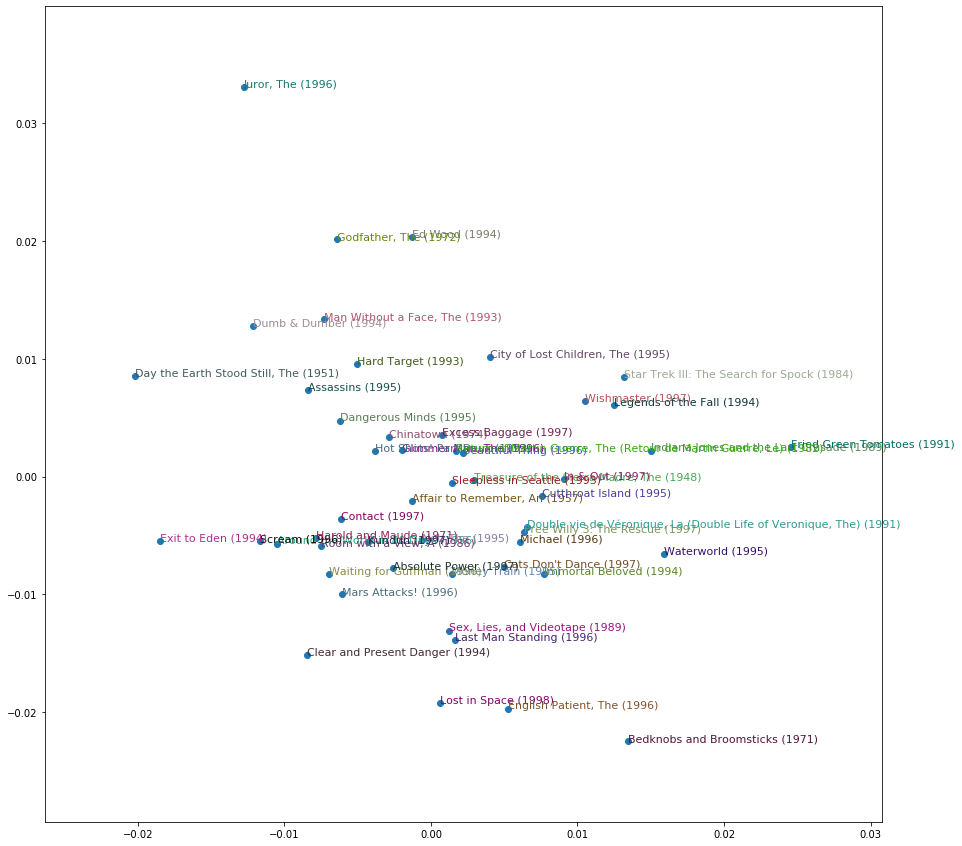

(None,
 numpy.ndarray,
 tensor([ 0.0125, -0.0013, -0.0029, -0.0051,  0.0008,  0.0050,  0.0064,  0.0040,
          0.0077,  0.0061,  0.0029,  0.0014,  0.0022,  0.0150, -0.0105,  0.0012,
         -0.0013, -0.0061, -0.0084, -0.0020, -0.0006,  0.0134, -0.0075, -0.0117,
         -0.0185,  0.0015, -0.0202, -0.0038,  0.0006,  0.0091, -0.0128,  0.0066,
          0.0053, -0.0079,  0.0016,  0.0105, -0.0085,  0.0132,  0.0246, -0.0070,
          0.0159,  0.0017, -0.0073, -0.0064, -0.0121, -0.0062, -0.0026, -0.0043,
          0.0076, -0.0061]),
 tensor([ 0.0061,  0.0203,  0.0033,  0.0095,  0.0035, -0.0076, -0.0047,  0.0102,
         -0.0083, -0.0055, -0.0003, -0.0083,  0.0020,  0.0022, -0.0057, -0.0131,
         -0.0021, -0.0100,  0.0074,  0.0022, -0.0054, -0.0225, -0.0059, -0.0055,
         -0.0055, -0.0005,  0.0085,  0.0022, -0.0192, -0.0002,  0.0331, -0.0043,
         -0.0197, -0.0052, -0.0139,  0.0064, -0.0151,  0.0084,  0.0025, -0.0083,
         -0.0065,  0.0022,  0.0134,  0.0201,  0.0128,  0.

In [129]:
#idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show(),type(idxs), X,Y